Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 4

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 60% accuracy (above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)
- [ ] Stacking Ensemble. (See below)

### Stacking Ensemble

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [61]:
import category_encoders as ce
import numpy as np
from scipy.stats import randint, uniform
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
my_train, my_val = train_test_split(train, random_state=42)

In [14]:
def wrangler(dataframe):
    x = dataframe.copy()
      # New Feature
    x['date_recorded_year'] = x['date_recorded'].str[:4].astype(int)
    x['years_before_service'] = x['date_recorded_year'] - x['construction_year']
    x.loc[(x['years_before_service']<0) | (x['years_before_service']>100), 'years_before_service'] = np.nan

      # Replace None, none, 0 with NaN values, and fix long/lat columns
    features_replace = ['scheme_name', 'installer', 'funder', 'wpt_name', 'longitude', 'latitude']
    x[features_replace] = x[features_replace].replace({'None':np.nan, 'none':np.nan, '0':np.nan, 0:np.nan, -2e-8:np.nan})

      # Drop id
    drops = ['id', 'recorded_by']
    x = x.drop(drops, axis=1)

    return x

In [15]:
target = 'status_group'
wrangled_train = wrangler(my_train)
wrangled_val = wrangler(my_val)

X_train = wrangled_train.drop(target, axis=1)
X_val = wrangled_val.drop(target, axis=1)
y_train = wrangled_train[target]
y_val = wrangled_val[target]

In [16]:
# Using params from best submission in previous notebook
pipeline = make_pipeline(
    ce.OrdinalEncoder(handle_missing = 'value', handle_unknown = 'return_nan'),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    RandomForestClassifier(max_depth = None, max_features = 0.0803875104989975, n_estimators = 962,random_state=42, n_jobs=-1)
)
pipeline.fit(X_train, y_train)
pipeline.score(X_val, y_val)

0.811043771043771

In [17]:
y_pred = pipeline.predict(X_val)

## Build confusion matrix

In [19]:
cmatrix = confusion_matrix(y_val,y_pred)

In [20]:
cmatrix

array([[7211,  194,  693],
       [ 543,  386,  145],
       [1137,   94, 4447]], dtype=int64)

In [23]:
unique_labels(y_pred), unique_labels(y_val)

(array(['functional', 'functional needs repair', 'non functional'],
       dtype='<U23'),
 array(['functional', 'functional needs repair', 'non functional'],
       dtype='<U23'))

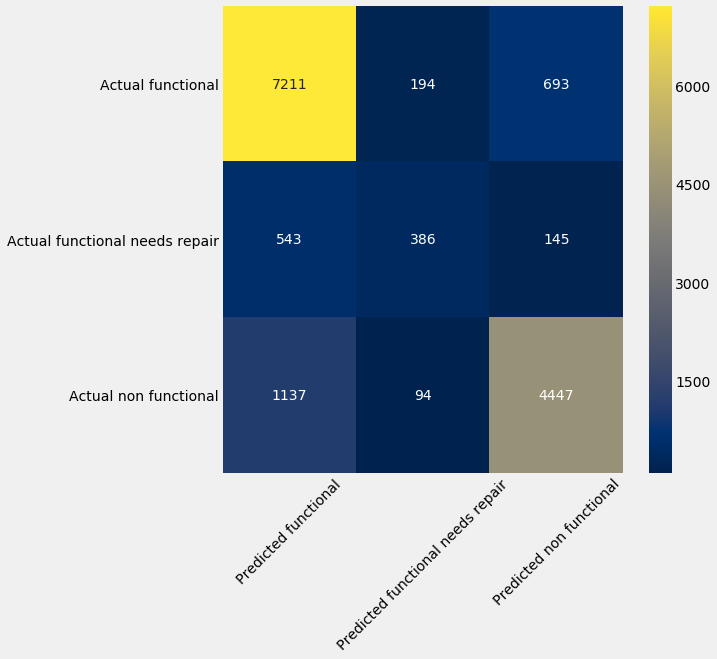

In [56]:
labels = unique_labels(y_pred)
columns = (f'Predicted {i}' for i in labels)
index = (f'Actual {i}' for i in labels)

with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(figsize=(8,8))

    sns.heatmap(cmatrix, ax=ax, annot=True, fmt='d', cmap='cividis')
    ax.set_ylim(3,0)
    ax.set_xlim(0,3)
    ax.set_xticklabels(columns, rotation=45)
    ax.set_yticklabels(index, rotation=0)

In [60]:
class_report = classification_report(y_val, y_pred)
print(class_report)

                         precision    recall  f1-score   support

             functional       0.81      0.89      0.85      8098
functional needs repair       0.57      0.36      0.44      1074
         non functional       0.84      0.78      0.81      5678

               accuracy                           0.81     14850
              macro avg       0.74      0.68      0.70     14850
           weighted avg       0.81      0.81      0.81     14850



## Never did gridsearchcv yesterday, let's try it

In [71]:
new_pipe = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
    RandomForestClassifier(random_state=42)
)

params = {
    'ordinalencoder__handle_unknown': ['return_nan', 'value'], 
    'ordinalencoder__handle_missing': ['return_nan', 'value'], 
    'simpleimputer__strategy': ['mean', 'median', 'most_frequent'], 
    'randomforestclassifier__n_estimators': range(1, 1001, 100), 
    'randomforestclassifier__max_depth': [None], 
#     'randomforestclassifier__max_features': uniform(0, 1), 
}

search = GridSearchCV(
    new_pipe,
    param_grid = params,
    n_jobs=-1,
    cv = 3,
    verbose=15,
    scoring = 'accuracy',
    return_train_score=True
)
search.fit(X_train,y_train)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('ordinalencoder',
                                        OrdinalEncoder(cols=None,
                                                       drop_invariant=False,
                                                       handle_missing='value',
                                                       handle_unknown='value',
                                                       mapping=None,
                                                       return_df=True,
                                                       verbose=0)),
                                       ('simpleimputer',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values

In [73]:
print(search.best_params_)
print(search.best_score_)

{'ordinalencoder__handle_missing': 'value', 'ordinalencoder__handle_unknown': 'return_nan', 'randomforestclassifier__max_depth': None, 'randomforestclassifier__n_estimators': 701, 'simpleimputer__strategy': 'mean'}
0.8050280583613917


In [78]:
piper = search.best_estimator_

In [79]:
piper.score(X_val, y_val)

0.8093602693602694

In [80]:
# why not make a submission
X_test = wrangler(test)
y_pred = piper.predict(X_test)
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('maybe.csv', index=False)